# Телеком — Определение неэффективных операторов

Задача:
Необходимо в «Нупозвони» найти самых неэффективных операторов для разработки алгоритма для встраивания в сервис обработки звонков как встраиваемый функционал.

Признаки низкой эффективности:
* много пропущенных входящих вызовов
* долгое ожидания ответа при входящих внешних вызовах
* мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков

Описание данных

Файл *telecom_dataset.csv*
* *user_id* - Идентификатор клиентского аккаунта колл-центра в сервисе
* *date* - Дата статистики
* *direction* - Направление вызовов (out - исходящий вызов, in — входящий вызов)
* *internal* - Является ли звонок внутренним звонком между операторами клиента
* *operator_id* - Идентификатор оператора
* *is_missed_call* - Является ли звонок пропущенным
* *calls_count* - Количество звонков
* *call_duration* - Длительность звонка (без учета времени ожидания)
* *total_call_duration* - Длительность звонка (с учетом времени ожидания)

Файл *telecom_clients.csv*
* *user_id* - Идентификатор клиентского аккаунта в сервисе
* *tariff_plan* - Текущий тарифный план клиента
* *date_start* - Дата регистрации клиентв в сервисе

Этапы исследования:
1. [Изучение общей информации](#a)
2. [Предобработка данных](#b)
* [Изменение типов данных](#b1)
* [Поиск дубликатов](#b2)
* [Поиск пропущенных значений](#b3)
* [Поиск выбросов](#b4)
3.[Исследовательский анализ данных](#c)
* [Распределения в данных](#c1) 
* [Описание тарифов А,В и С](#c3)
4.[Определение неэффективных операторов](#d)
* [Критерий "много пропущенных входящих вызовов"](#d1)
* [Критерий "долгое ожидания ответа при входящих внешних вызовах"](#d2)
* [Критерий "мало исходящих вывозов"](#d3)
* [Вывод](#d4)
5.[Проверка статистических гипотез](#e)
* [Время ожидания ответа на тарифе A отличается от тарифа B.](#e1)
* [Время ожидания ответа на тарифе B отличается от тарифа C.](#e2)
* [Длительность входящих звонков на тарифе А отличается от В.](#e3)
6.[Вывод](#f)

## Изучение общей информации
<a id="a"></a> 

In [1]:
#загрузка библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns
from datetime import datetime
from datetime import date
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')


In [2]:
#загрузка датафреймов
pd.options.mode.chained_assignment = None
df_telecom_c = pd.read_csv('/datasets/telecom_clients.csv')
df_telecom_d = pd.read_csv('/datasets/telecom_dataset.csv')

In [3]:
df = pd.merge(df_telecom_d, df_telecom_c, on='user_id', how='left')

In [4]:
df.head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,B,2019-08-01
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29,B,2019-08-01
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50,B,2019-08-01
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35,B,2019-08-01
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50,B,2019-08-01
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62,B,2019-08-01


In [5]:
#посмотрим тип данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53902 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
 9   tariff_plan          53902 non-null  object 
 10  date_start           53902 non-null  object 
dtypes: bool(1), float64(1), int64(4), object(5)
memory usage: 4.6+ MB


**Вывод:**

Таблица df состоит из 53902 строк. C названиями столбцов все в порядке, только нужно изменить тип данных в столбце operator_id на int, date и date_start на date.

## Предобработка данных
<a id="b"></a>

* Изменение типов данных
<a id="b1"></a>

In [6]:
#date_start на datetime
df['date_start'] = pd.to_datetime(df['date_start'])

In [7]:
#date на datetime
df['date'] = pd.to_datetime(df['date']).dt.date
df['date'] = pd.to_datetime(df['date'])

Необходимо перевести operator_id в формат int64 но нам не позволяет наличие NAN. Решим это в поиске пропущенных значений. 

In [8]:
#operator_id на int64
df['operator_id'] = df['operator_id'].astype('int64', errors = 'ignore')

In [9]:
#проверка 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53902 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53902 non-null  int64         
 1   date                 53902 non-null  datetime64[ns]
 2   direction            53902 non-null  object        
 3   internal             53785 non-null  object        
 4   operator_id          45730 non-null  float64       
 5   is_missed_call       53902 non-null  bool          
 6   calls_count          53902 non-null  int64         
 7   call_duration        53902 non-null  int64         
 8   total_call_duration  53902 non-null  int64         
 9   tariff_plan          53902 non-null  object        
 10  date_start           53902 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 4.6+ MB


* Поиск дубликатов
<a id="b2"></a>

In [10]:
#Проверим количество дубликатов
print('Сумма дубликатов:',df.duplicated().sum())

Сумма дубликатов: 4900


Всего дубликатов 4900. Избавимся от них

In [11]:
#избавляемся от дубликатов в 
df = df.drop_duplicates().reset_index(drop = True)

In [12]:
#проверка 
print('Проверка сумма дубликатов:',df.duplicated().sum())

Проверка сумма дубликатов: 0


* Поиск пропущенных значений
<a id="b3"></a>

In [13]:
df.isnull().mean()

user_id                0.000000
date                   0.000000
direction              0.000000
internal               0.002245
operator_id            0.152157
is_missed_call         0.000000
calls_count            0.000000
call_duration          0.000000
total_call_duration    0.000000
tariff_plan            0.000000
date_start             0.000000
dtype: float64

Есть пропуски в operator_id и internal. 
Пропуски в operator_id заполним 0 И поменяем формат столбца на int64.
В internal пропусков мало, заполним их 0.

In [14]:
#заполним 0 operator_id
df['operator_id'] = df['operator_id'].fillna(0)

In [15]:
#заполним пропуски в internal нулями
df['internal'] = df['internal'].fillna(0)

In [16]:
#operator_id на int64
df['operator_id'] = df['operator_id'].astype('int64', errors = 'ignore')

In [17]:
#проверка 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             49002 non-null  object        
 4   operator_id          49002 non-null  int64         
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
 9   tariff_plan          49002 non-null  object        
 10  date_start           49002 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), int64(5), object(3)
memory usage: 3.8+ MB


* Поиск выбросов
<a id="b4"></a>

Проверим данные на выбросы по количеству звонков(calls_count)

In [18]:
#данные по количеству звонков
df[['calls_count']].describe().round()

,calls_count
count,49002.0
mean,16.0
std,64.0
min,1.0
25%,1.0
50%,4.0
75%,12.0
max,4817.0


4000 звонков при среднем 17 выглядят подозрительно. Посчитаем верхний квантиль, тем самым определимся с верхними выбросами. И удалим 1% данных. 

In [19]:
q_hi  = df['calls_count'].quantile(0.99)
df = df[(df['calls_count'] < q_hi)]

In [20]:
df[['calls_count']].describe().round()

,calls_count
count,48510.0
mean,12.0
std,20.0
min,1.0
25%,1.0
50%,4.0
75%,12.0
max,164.0


Проверим данные о длительности звонков.

In [21]:
#call_duration
df[['call_duration']].describe().round()

,call_duration
count,48510.0
mean,686.0
std,1690.0
min,0.0
25%,0.0
50%,37.0
75%,562.0
max,52541.0


Посчитаем верхний квантиль, тем самым определимся с верхними выбросами. И удалим 1% данных. 

In [22]:
q_hi  = df['call_duration'].quantile(0.99)
df = df[(df['call_duration'] < q_hi)]

In [23]:
#call_duration
df[['call_duration']].describe().round()

,call_duration
count,48024.0
mean,572.0
std,1209.0
min,0.0
25%,0.0
50%,34.0
75%,530.0
max,8685.0


Проверим длительность звонков с ожиданием

In [24]:
#total_call_duration
df[['total_call_duration']].describe().round()

,total_call_duration
count,48024.0
mean,769.0
std,1381.0
min,0.0
25%,45.0
50%,196.0
75%,818.0
max,11571.0


При максимальной длительности звонка 8685 сек, длительность в 11571 вполне логична. Тут оставляем все как есть.

Вывод: При анализе выбросов убрали 1% данных из столбца calls_count и 1% из call_duration. Это были верхние квартили, которые смещали данные в неадекватно большую сторону. 

## Исследовательский анализ данных
<a id="c"></a>

* Распределения в данных 
<a id="c1"></a>

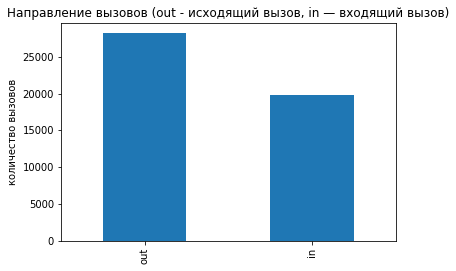

In [25]:
#Построим диаграмму направлений вызовов
df['direction'].value_counts().plot(kind='bar')
plt.title('Направление вызовов (out - исходящий вызов, in — входящий вызов)')
plt.ylabel('количество вызовов');

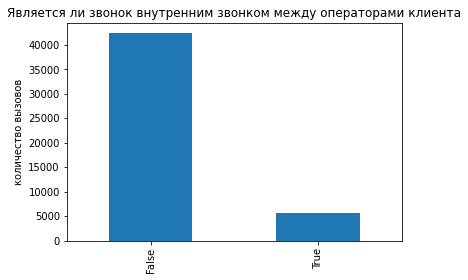

In [26]:
#Построим диаграмму количества внутренних звонков
df['internal'].value_counts().plot(kind='bar')
plt.title('Является ли звонок внутренним звонком между операторами клиента')
plt.ylabel('количество вызовов');

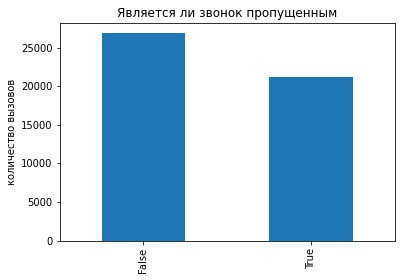

In [27]:
#Построим диаграмму количества пропущенных звонков
df['is_missed_call'].value_counts().plot(kind='bar')
plt.title('Является ли звонок пропущенным')
plt.ylabel('количество вызовов');

In [28]:
#количетво тарифов
count_tariff = df['tariff_plan'].value_counts()
count_tariff

C    18089
B    17163
A    12772
Name: tariff_plan, dtype: int64

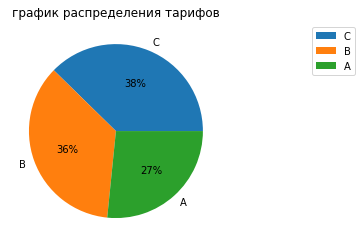

In [29]:
#график тарифов
count_tariff.plot(kind='pie', label="", subplots=True, autopct='%1.0f%%')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper center')
plt.title('график распределения тарифов');

In [30]:
#Добавим столбец с днем недели где 0-понедельник
df['weekday'] = df.loc[:, 'date'].dt.weekday
df['weekday']

0        6
1        0
2        0
3        0
4        0
        ..
48997    6
48998    6
48999    0
49000    4
49001    1
Name: weekday, Length: 48024, dtype: int64

<AxesSubplot:xlabel='weekday'>

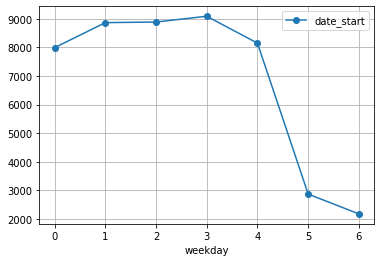

In [31]:
#посмотрим в какой день недели было большее количество регистраций
start=df.pivot_table(index=['weekday'],values='date_start', aggfunc='count')
start.sort_values(by='date_start',ascending=False)
start.plot(style='o-', grid=True)

**Вывод:** В основном мы имеем данные про исходящие внешние вызовы, которые имеют большую долю принятых. Доли тарифных планов примерно одинаковые. В основном регистрации клиентов происходят в будни. Больше всего регистраций произошло в четверг, самое меньшее количество в воскресенье. 

* Описание тарифов А,В и С
<a id="c3"></a>

In [32]:
#сделаем срез для тарифа А
A=df.query('tariff_plan == "A"')

In [33]:
#сделаем срез для тарифа B
B=df.query('tariff_plan == "B"')

In [34]:
#сделаем срез для тарифа C
C=df.query('tariff_plan == "C"')

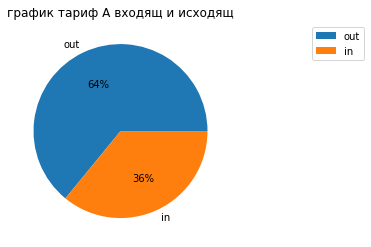

In [35]:
count_direction_A = A['direction'].value_counts()
count_direction_A.plot(kind='pie', label="", subplots=True, autopct='%1.0f%%')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper center')
plt.title('график тариф А входящ и исходящ');

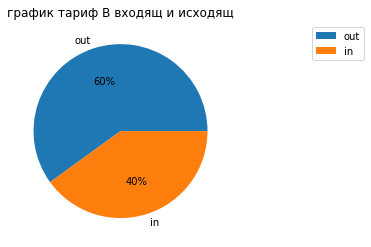

In [36]:
count_direction_B = B['direction'].value_counts()
count_direction_B.plot(kind='pie', label="", subplots=True, autopct='%1.0f%%')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper center')
plt.title('график тариф B входящ и исходящ');

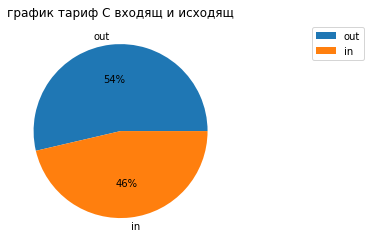

In [37]:
count_direction_C = C['direction'].value_counts()
count_direction_C.plot(kind='pie', label="", subplots=True, autopct='%1.0f%%')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper center')
plt.title('график тариф C входящ и исходящ');

Все тарифы в основном работают на исходящие вызовы.

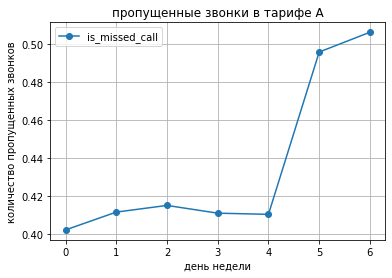

In [38]:
#Посмотрим график зависимости количества пропущенных звонков от дня недели тариф А
A.pivot_table(index='weekday', values='is_missed_call').plot(style='o-', grid=True) 

plt.title('пропущенные звонки в тарифе А')
plt.ylabel('количество пропущенных звонков')
plt.xlabel('день недели');

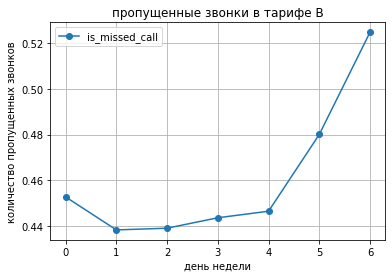

In [39]:
#Посмотрим график зависимости количества пропущенных звонков от дня недели тариф В
B.pivot_table(index='weekday', values='is_missed_call').plot(style='o-', grid=True) #Посмотрим график зависимости цены от типа этажа

plt.title('пропущенные звонки в тарифе B')
plt.ylabel('количество пропущенных звонков')
plt.xlabel('день недели');

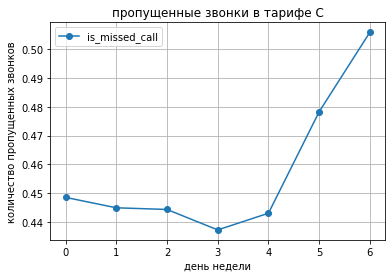

In [40]:
#Посмотрим график зависимости количества пропущенных звонков от дня недели тариф С
C.pivot_table(index='weekday', values='is_missed_call').plot(style='o-', grid=True) #Посмотрим график зависимости цены от типа этажа

plt.title('пропущенные звонки в тарифе C')
plt.ylabel('количество пропущенных звонков')
plt.xlabel('день недели');

Больше всего пропущенных звонков в субботу и воскресенье.Это заметно во всех тарифах

In [41]:
#выведем таблицу количества пропущенных звонков в тарифе А
top_miss_A = A.pivot_table(index=['user_id'],values='is_missed_call', aggfunc='sum').sort_values(by='is_missed_call', ascending=False).head(5)
top_miss_A

,is_missed_call
user_id,
168187,764
167626,578
168361,567
167497,482
168062,467


In [42]:
#выведем таблицу количества пропущенных звонков в тарифе В
top_miss_B = B.pivot_table(index=['user_id'],values='is_missed_call', aggfunc='sum').sort_values(by='is_missed_call', ascending=False)
top_miss_B.head(5)

,is_missed_call
user_id,
166658,827
166405,416
166485,311
166377,248
167359,247


In [43]:
#выведем таблицу количества пропущенных звонков в тарифе С
top_miss_C = C.pivot_table(index=['user_id'],values='is_missed_call', aggfunc='sum').sort_values(by='is_missed_call', ascending=False)
top_miss_C.head(5)

,is_missed_call
user_id,
167150,444
166511,379
166983,362
167125,337
166782,326


У каждого тарифа есть свои лидеры. Нет ни одного общего кол-центра по количетсву пропущенных вызовов.Соответственно проводить анализ пропущенных звонков в разрезе тарифов нет смысла. 

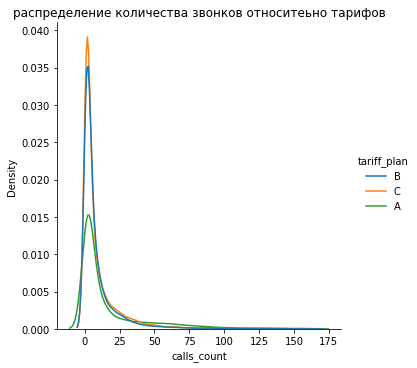

In [44]:
#распределение количества звонков относитеьно тарифов
sns.displot(x='calls_count', hue='tariff_plan', kind='kde', data=df)
plt.title('распределение количества звонков относитеьно тарифов')
plt.show()

Больше всего звонков производится на тарифах C и В. 

<div class="alert alert-success">
    
**Комментарий ревьюера**

**#ок**

В качестве описательной статистики эта часть подойдет
</div>


## Определение неэффективных операторов
<a id="d"></a>

In [45]:
#создадим список кол-центров с количествои входящих и исходящих звонков
df_kc=df.pivot_table(index = 'user_id',  columns = 'direction', values = 'calls_count', aggfunc = 'sum').fillna(0).reset_index()
#добавим столбцы с процентами входящих и исходящих звонков
df_kc['proc_in']=(df_kc['in']/(df_kc['in']+df_kc['out'])*100).round()
df_kc['proc_out']=(df_kc['out']/(df_kc['in']+df_kc['out'])*100).round()
df_kc

direction,user_id,in,out,proc_in,proc_out
0,166377,196.0,4953.0,4.0,96.0
1,166391,26.0,1.0,96.0,4.0
2,166392,209.0,0.0,100.0,0.0
3,166399,24.0,0.0,100.0,0.0
4,166405,5286.0,9385.0,36.0,64.0
...,...,...,...,...,...
302,168583,40.0,0.0,100.0,0.0
303,168598,102.0,0.0,100.0,0.0
304,168601,105.0,587.0,15.0,85.0
305,168603,1.0,14.0,7.0,93.0


Напишем функцию, в которой разделим все кол центры по принципу: если процент выше 70, то отнесем к определенной группе(только исходящие или только входящие). КЦ не попавшие ни под один отбор, отнесем в группу КЦ с входяшими и исходящими звонками.

In [46]:
#напишем функцию, в которой определим процент
def group(x):
    if x['proc_in'] > 70:
        return "group_in"
    if x['proc_out'] > 70:
        return "group_out"
    return "group_in_out"

In [47]:
df_kc['group']=df_kc.apply(group,axis=1)
df_kc

direction,user_id,in,out,proc_in,proc_out,group
0,166377,196.0,4953.0,4.0,96.0,group_out
1,166391,26.0,1.0,96.0,4.0,group_in
2,166392,209.0,0.0,100.0,0.0,group_in
3,166399,24.0,0.0,100.0,0.0,group_in
4,166405,5286.0,9385.0,36.0,64.0,group_in_out
...,...,...,...,...,...,...
302,168583,40.0,0.0,100.0,0.0,group_in
303,168598,102.0,0.0,100.0,0.0,group_in
304,168601,105.0,587.0,15.0,85.0,group_out
305,168603,1.0,14.0,7.0,93.0,group_out


In [48]:
#общая информация по количеству КЦ в разрезе групп
out=df_kc.query('group == "group_out"')
print('Количество исходящих КЦ:',out['user_id'].nunique())
uno=df_kc.query('group == "group_in"')
print('Количество входящих КЦ:',uno['user_id'].nunique())
no=df_kc.query('group == "group_in_out"')
print('Количество вход/исход КЦ:',no['user_id'].nunique())

Количество исходящих КЦ: 87
Количество входящих КЦ: 145
Количество вход/исход КЦ: 75


In [49]:
#добавлю столбец group в df
df_kc=df_kc[['user_id','group']]
df=df.merge(df_kc, on='user_id',how='left')

**Вывод:** Мы имеем три списка операторов:
* которые специализируются только на исходящих звонках-87 шт.
* которые специализируются только на входящих звонках - 145 шт.
* которые специализируются на входящих и на исходящих - 75шт.

* Критерий "много пропущенных входящих вызовов"
<a id="d1"></a>

Этот критерий при анализе KPI кол-центров называется CAR (AAR – англ. average abandonment rate — неотработанные вызовы).Стандартом CAR считается 5–8%. [ссылка на источник](https://www.ifc.org/wps/wcm/connect/3a656e01-ad18-459a-b1ed-87784c1f1616/Tool+9.4.+Measuring+Call+Center+Performance.pdf?MOD=AJPERES&CVID=jENLHxM) Мы возьмем средний процент-7%. пропущенных от всего количества входящих звонков.

In [50]:
#соберем таблицу с данными по звонкам
listr=df.pivot_table(index = 'user_id',  columns = 'is_missed_call', values = 'calls_count', aggfunc = 'sum').fillna(0).reset_index()
listr.columns = ['user_id','непропущенный', 'пропущенный']
listr['sum']=listr['непропущенный']+listr['пропущенный']
listr['miss_%']=(listr['пропущенный']/listr['sum']*100).round()#выведем столбец с пропущенными звонками
listr.astype('Int64')
listr=listr[['user_id','miss_%']]
df=df.merge(listr,on='user_id', how='left')#добавим этот столбец к df
df

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,weekday,group,miss_%
0,166377,2019-08-04,in,False,0,True,2,0,4,B,2019-08-01,6,group_out,37.0
1,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01,0,group_out,37.0
2,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01,0,group_out,37.0
3,166377,2019-08-05,out,True,880020,False,1,10,18,B,2019-08-01,0,group_out,37.0
4,166377,2019-08-05,out,False,880022,True,3,0,25,B,2019-08-01,0,group_out,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48019,168606,2019-11-10,out,True,957922,False,1,0,25,C,2019-10-31,6,group_in_out,44.0
48020,168606,2019-11-10,out,True,957922,True,1,0,38,C,2019-10-31,6,group_in_out,44.0
48021,168606,2019-11-11,out,True,957922,False,2,479,501,C,2019-10-31,0,group_in_out,44.0
48022,168606,2019-11-15,out,True,957922,False,4,3130,3190,C,2019-10-31,4,group_in_out,44.0


* Критерий "долгое ожидания ответа при входящих внешних вызовах"
<a id="d2"></a>

Этот критерий при анализе KPI кол-центров называется Service level (SL)— уровень обслуживания. Ожидание ответа не должно превышать 20 сек. [ссылка на источник](https://www.ifc.org/wps/wcm/connect/3a656e01-ad18-459a-b1ed-87784c1f1616/Tool+9.4.+Measuring+Call+Center+Performance.pdf?MOD=AJPERES&CVID=jENLHxM)

In [51]:
#столбец с длительностью ожидания
df['wait']=(df['total_call_duration']-df['call_duration'])/df['calls_count']

* Критерий "мало исходящих вывозов"
<a id="d3"></a>

Средняя длительность звонка должна составлять 4 мин.,как говорится в отчете о статистике международной финансовой комиссии [ссылка на отчет](https://www.ifc.org/wps/wcm/connect/3a656e01-ad18-459a-b1ed-87784c1f1616/Tool+9.4.+Measuring+Call+Center+Performance.pdf?MOD=AJPERES&CVID=jENLHxM). Соответственно  среднее кол-во звонков в день которое должен совершать оператор = 120.

Мы посчитаем количество дней в данных. 

In [52]:
#минимальная дата
df.date_start.min()

Timestamp('2019-08-01 00:00:00')

In [53]:
#максимальная дата
df.date_start.max()

Timestamp('2019-10-31 00:00:00')

In [54]:
#посчитаем количество дней в данных
d0 = date(2019, 8, 1)
d1 = date(2019, 10, 31)
delta = d1 - d0
print('Количество дней:', delta.days)

Количество дней: 91


In [55]:
#соберем таблицу
f=df.pivot_table(index = 'user_id', values = 'calls_count', aggfunc = 'sum').fillna(0).reset_index()
f['cool_mean']=f['calls_count']/91 #посчитаем среднее количество звонков в день
f

,user_id,calls_count,cool_mean
0,166377,5149,56.582418
1,166391,27,0.296703
2,166392,209,2.296703
3,166399,24,0.263736
4,166405,14671,161.219780
...,...,...,...
302,168583,40,0.439560
303,168598,102,1.120879
304,168601,692,7.604396
305,168603,15,0.164835


In [56]:
f=f[['user_id','cool_mean']]
#присоединим столбец со средним количеством звонков в день
df = df.merge(f,on='user_id', how='left')

* Вывод
<a id="d4"></a>

In [57]:
#напишем функцию, в которой укажем критерии неэффективности
def effect(row):
    if row['direction'] == "in" and row['is_missed_call']=="True" and row['miss_%'] >= 7:#Критерий "много пропущенных входящих вызовов"
        return "noeffect"
    if row['direction'] == "in" and row['internal']=="False" and row['wait'] >= 20:#Критерий "долгое ожидания ответа при входящих внешних вызовах"
        return "noeffect"
    if row['direction'] == "out" and row['cool_mean'] <= 120:#Критерий "мало исходящих вывозов"
        return "noeffect"
    return "effect"

In [58]:
#создадим столбец с показателем эффективности
df['effect'] = df.apply(effect,axis=1)

In [59]:
#посмотрим сколько всего неэффективных операторов получили
operator_all=df['operator_id'].nunique()
print('всего операторов', operator_all)
user_all=df['user_id'].nunique()
print('всего кц', user_all)
noef_sum=df.query('effect=="noeffect"')
qw=noef_sum['operator_id'].nunique()
we=noef_sum['user_id'].nunique()                
print('количество неэффективных операторов',qw)
print('количество неэффективных кц',we)               
print(f'Процент неэффективных операторов:{(qw/operator_all):.0%}')

всего операторов 1093
всего кц 307
количество неэффективных операторов 668
количество неэффективных кц 211
Процент неэффективных операторов:61%


Мы определили количество неэффективных операторов. Теперь посмотрим как неэффективные операторы распределены по КЦ в разрезе трех групп(входящ,исх,входящ/исходящ).

In [60]:
#посмотрим распределение неэффективных операторов в группе входящих
inn= df.query('group=="group_in"')
in_sum_op= inn['operator_id'].nunique()
in_sum_us= inn['user_id'].nunique()            
innd=df.query('group=="group_in" and effect=="noeffect"')
operator_in_no=innd['operator_id'].nunique()
user_in_no=innd['user_id'].nunique()             
print('Количество неэффективных операторов в группе входящих:', operator_in_no)
print('Количество неэффективных КЦ в группе входящих:', user_in_no)
procent=operator_in_no/in_sum_op
print(f'Процент неэффективных операторов в группе входящих:{(procent):.0%}')

Количество неэффективных операторов в группе входящих: 112
Количество неэффективных КЦ в группе входящих: 60
Процент неэффективных операторов в группе входящих:43%


In [61]:
#посмотрим распределение неэффективных операторов в группе исходящих
outt= df.query('group=="group_out"')
out_sum_op= outt['operator_id'].nunique()
out_sum_us= outt['user_id'].nunique() 
outtd=df.query('group=="group_out" and effect=="noeffect"')
operator_out_no=outtd['operator_id'].nunique()
user_out_no=outtd['user_id'].nunique()             
print('Количество неэффективных операторов в группе исходящих:', operator_out_no)
print('Количество неэффективных КЦ в группе исходящих:', user_out_no)
procent=operator_out_no/out_sum_op
print(f'Процент неэффективных операторов в группе исходящих:{(procent):.0%}')

Количество неэффективных операторов в группе исходящих: 345
Количество неэффективных КЦ в группе исходящих: 81
Процент неэффективных операторов в группе исходящих:68%


In [62]:
#посмотрим распределение неэффективных операторов в группе исходящих и входящих
in_out= df.query('group=="group_in_out"')
in_out_sum_op= in_out['operator_id'].nunique()
in_out_sum_us= in_out['user_id'].nunique()            
in_outd=df.query('group=="group_in_out" and effect=="noeffect"')
operator_in_out_no=in_outd['operator_id'].nunique()
user_in_out_no=in_outd['user_id'].nunique()             
print('Количество неэффективных операторов в группе входящих и исходящих:', operator_in_out_no)
print('Количество неэффективных КЦ в группе входящих и исходящих:', user_in_out_no)
procent=operator_in_out_no/in_out_sum_op
print(f'Процент неэффективных операторов в группе входящих и исходящих:{(procent):.0%}')

Количество неэффективных операторов в группе входящих и исходящих: 213
Количество неэффективных КЦ в группе входящих и исходящих: 70
Процент неэффективных операторов в группе входящих и исходящих:64%


Больше всего заинтересованы в новом сервисе КЦ, которые имеют более 50% неэффективных операторов. Эти КЦ специализируются на:

* исходящих звонках. Они имеют 68% неэффективных операторов.Количество потенциальных покупателей 81 КЦ.
* исходящих и входящих. Они имеют 64% неэффективных оператора.Количество потенциальных покупателей 70 КЦ.

Разработка сервиса будет оправдана, потому как КЦ, в общей сложности, имеют 60% неэффективных операторов.

## Проверка статистических гипотез
<a id="e"></a>

* Время ожидания ответа на тарифе A отличается от тарифа B.
<a id="e1"></a>

H0 - Время ожидания ответа на тарифе A не отличается от тарифа B.

H1 - Время ожидания ответа на тарифе A отличается от тарифа B.

In [63]:
#Сформируем данные для проверки гипотезы
wait_tariff_A = df.query(' tariff_plan == "A" ')['wait'].dropna().to_list()
wait_tariff_B = df.query(' tariff_plan == "B" ')['wait'].dropna().to_list()

alpha = 0.05

results = st.ttest_ind(
    wait_tariff_A, 
    wait_tariff_B,
    nan_policy='omit',
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10943219662818052
Не получилось отвергнуть нулевую гипотезу


Время ожидания ответа на тарифе A отличается от тарифа B.

* Время ожидания ответа на тарифе B не отличается от тарифа C.
<a id="e2"></a>

H0 - Время ожидания ответа на тарифе В не отличается от тарифа С.

H1 - Время ожидания ответа на тарифе B отличается от тарифа C.

In [64]:
#Сформируем данные для проверки гипотезы
wait_tariff_B = df.query(' tariff_plan == "B" ')['wait'].dropna().to_list()
wait_tariff_C = df.query(' tariff_plan == "C" ')['wait'].dropna().to_list()

alpha = 0.05

results = st.ttest_ind(
    wait_tariff_B, 
    wait_tariff_C,
    nan_policy='omit',
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.2200498431808827e-16
Отвергаем нулевую гипотезу


Время ожидания ответа на тарифе В отличается от тарифа С.

* Длительность входящих звонков на тарифе А отличается от В.
<a id="e3"></a> 

H0 - Длительность входящих звонков на тарифе А отличается от тарифа В.

H1 - Длительность входящих звонков на тарифе А не отличается от тарифа В.

In [65]:
df=df.query('direction == "in"')

In [66]:
#Сформируем данные для проверки гипотезы
tariff_A = df.query(' tariff_plan == "A" ')['call_duration'].dropna().to_list()
tariff_B = df.query(' tariff_plan == "B" ')['call_duration'].dropna().to_list()

alpha = 0.05

results = st.ttest_ind(
    tariff_A, 
    tariff_B,
    nan_policy='omit',
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 9.047544035024045e-06
Отвергаем нулевую гипотезу


Длительность входящих звонков на тарифе А не отличается от тарифа В.

## Вывод
<a id="f"></a>

Получены два датафрейма с данными. Они были соеденены в один. Над датафреймом была произведена предобработка и анализ данных, в ходе которого выяснено: 
* В основном представлены данные про исходящие внешние вызовы, которые имеют большую долю принятых. Доли тарифных планов примерно одинаковые. 
* Регистрации клиентов происходят в будни. Больше всего регистраций произошло в четверг, самое меньшее количество в воскресенье. 
* Больше всего пропущенных звонков в субботу и воскресенье.

Произведен анализ по критериям. Разработка сервиса будет оправдана, потому как КЦ, в общей сложности, имеют 60% неэффективных операторов.